# Reparametrization test
In which cases model reparametrization is useful?

In [1]:
!hostname
!python -c "import jax; print(jax.default_backend(), jax.devices())"
# !nvidia-smi
# numpyro.set_platform("gpu")

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.33' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
from jax import random, jit, vmap, grad

import numpyro
import numpyro.distributions as dist
from numpyro import sample, deterministic
from numpyro.handlers import seed, condition, trace

%matplotlib inline
%load_ext autoreload 
%autoreload 2

feynmangpu04.cluster.local


gpu [cuda(id=0)]


## Define and reparametrize model

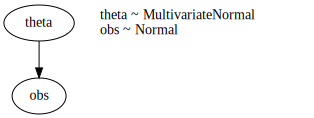

In [138]:
def model(mean=jnp.zeros(2), covar=jnp.eye(2), vec=jnp.ones(2), epsilon=1):
    theta = sample('theta', dist.MultivariateNormal(loc=mean, covariance_matrix=covar))
    proj = vec @ theta
    # obs = sample('obs', dist.Uniform(-epsilon + proj, epsilon + proj) )
    obs = sample('obs', dist.Normal(proj, epsilon) )
    return obs

from numpyro.infer.util import log_density
logp_fn = lambda xxyy_ij, obs, model_kwargs: log_density(model=model, 
                                        model_args=(), 
                                        model_kwargs=model_kwargs, 
                                        params={'theta': xxyy_ij,
                                                'obs': obs},)[0]
logp_vfn = jit(vmap(vmap(logp_fn, in_axes=(0,None,None)), in_axes=(0,None,None)))

numpyro.render_model(
    model=model,
    render_distributions=True,
    render_params=True,)

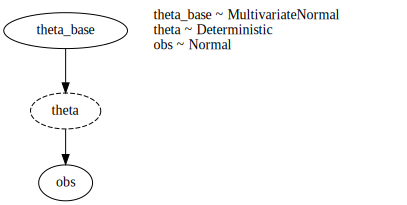

In [139]:
def reparam_model(mean=jnp.zeros(2), covar=jnp.eye(2), vec=jnp.ones(2), epsilon=1):
    dim = len(mean)
    theta_base = sample('theta_base', dist.MultivariateNormal(loc=jnp.zeros(dim), covariance_matrix=jnp.eye(dim)))
    L = jax.scipy.linalg.cholesky(covar)
    theta = deterministic('theta', L @ theta_base + mean)
    proj = vec @ theta
    # obs = sample('obs', dist.Uniform(-epsilon + proj, epsilon + proj) )
    obs = sample('obs', dist.Normal(proj, epsilon) )
    return obs

logp_rep_fn = lambda xxyy_ij, obs, model_kwargs: log_density(model=reparam_model, 
                                        model_args=(), 
                                        model_kwargs=model_kwargs, 
                                        params={'theta_base': xxyy_ij,
                                                'obs': obs},)[0]
logp_rep_vfn = jit(vmap(vmap(logp_rep_fn, in_axes=(0,None,None)), in_axes=(0,None,None)))

numpyro.render_model(
    model=reparam_model,
    render_distributions=True,
    render_params=True,)

## Show posteriors

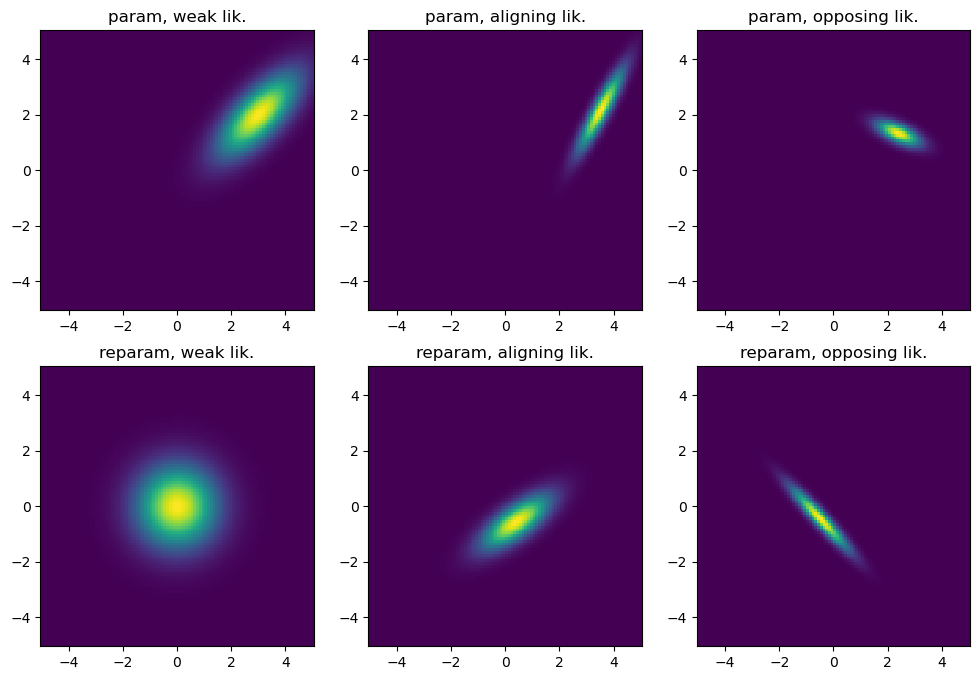

In [191]:
angle = jnp.pi/4
model_kwargs = {'mean':jnp.array([2,3]), 
                'covar':jnp.array([[1,jnp.cos(angle)],[jnp.cos(angle),1]]),}

box_corner = 5
n_discr = 100
box = np.array([[-box_corner, box_corner], [-box_corner, box_corner]])
xxyy = np.mgrid[[slice(box_ax[0],box_ax[1],n_discr*1j) 
                       for box_ax in box]]

obs = 5
plt.figure(figsize=(12,8))
model_kwargs['epsilon'] = 10
model_kwargs['vec'] = jnp.array([-1,2])
zz = jnp.exp(logp_vfn(xxyy.T, obs, model_kwargs))
zz_rep = jnp.exp(logp_rep_vfn(xxyy.T, obs, model_kwargs))
plt.subplot(231)
plt.pcolormesh(xxyy[0], xxyy[1], zz, cmap='viridis')
plt.title("param, weak lik.")
plt.subplot(234)
plt.pcolormesh(xxyy[0], xxyy[1], zz_rep, cmap='viridis')
plt.title("reparam, weak lik.")

model_kwargs['epsilon'] = .5
model_kwargs['vec'] = jnp.array([-1,2])
zz = jnp.exp(logp_vfn(xxyy.T, obs, model_kwargs))
zz_rep = jnp.exp(logp_rep_vfn(xxyy.T, obs, model_kwargs))
plt.subplot(232)
plt.pcolormesh(xxyy[0], xxyy[1], zz, cmap='viridis')
plt.title("param, aligning lik.")
plt.subplot(235)
plt.pcolormesh(xxyy[0], xxyy[1], zz_rep, cmap='viridis')
plt.title("reparam, aligning lik.")

model_kwargs['epsilon'] = .5
model_kwargs['vec'] = jnp.array([2,1])
zz = jnp.exp(logp_vfn(xxyy.T, obs, model_kwargs))
zz_rep = jnp.exp(logp_rep_vfn(xxyy.T, obs, model_kwargs))
plt.subplot(233)
plt.pcolormesh(xxyy[0], xxyy[1], zz, cmap='viridis')
plt.title("param, opposing lik.")
plt.subplot(236)
plt.pcolormesh(xxyy[0], xxyy[1], zz_rep, cmap='viridis')
plt.title("reparam, opposing lik.")
plt.show()

## Conclusion
* In the case of a model where the parameters are equally constrained, i.e. the likelihood is aligned with the prior, then it is better to reparametrize.
* In the case of a model where the likelihood constrain parameters unequally, it can sometimes be better not to reparametrize.